In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns
import sqlalchemy
import tensorflow as tf
import tensorflow.keras as keras

import energy.create_training_table as ctr
import energy.scaler
import energy.selects as selects
import energy.utils as utils

%reload_ext autoreload

# Aliases.
mean_squared_error = sklearn.metrics.mean_squared_error
Scaler = energy.scaler.Scaler


In [3]:
# Uncommend this to recreate the table.
ctr.create_training_table('ensemble_data')

In [5]:
engine = sqlalchemy.create_engine(selects.CONN_STR)

In [6]:
def plot_history(history):
    plt.clf()
    min_value, max_value = 1000, 0
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
        min_value = min(min_value, min(history.history[key]))
        max_value = max(max_value, max(history.history[key]))
    #plt.ylim([min_value, max_value])
    plt.ylim([0, max_value])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

def get_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

SQL = '''select total_load_forecast forecast, total_load_actual actual from energy;'''
f = pd.read_sql_query(SQL, con=engine)
f = f.dropna()

# MSE_IN_FILE: The mean squared error in the original csv file.
MSE_IN_FILE = get_mean_squared_error(f.forecast.to_numpy(), f.actual.to_numpy())

# Regressor


In [7]:
sql = """
select
    a.date_time,
    SIN (0.130 * hour + 1) as hour,
    load + data_diff as load,
    a.price_day_ahead,
    load as current_load,
    load2,
    load3,
    load5,
    load8,
    load13,
    load24,
    load37,
    diff2,
    diff3,
    diff5,
    diff8,
    diff13,
    diff24,
    diff37
from
ensemble_data a, energy b
where
    a.date_time = b.date_time and
    train = {train_flag}
order by a.date_time
""".format

engine = sqlalchemy.create_engine(selects.CONN_STR)

train_dataset = pd.read_sql_query(sql(train_flag=1), con=engine)
train_dataset = train_dataset.sample(frac=1.)

test_dataset = pd.read_sql_query(sql(train_flag=0), con=engine)

# Now break-down features and labels.
train_features = train_dataset.copy()
train_labels = pd.DataFrame(train_features.pop('load'))
train_features.pop('date_time')

test_features = test_dataset.copy()
test_labels = pd.DataFrame(test_features.pop('load'))
test_date_time = pd.DataFrame(test_features.pop('date_time')).copy()

# Create the scalers for features and labels.

feature_scaler = Scaler(train_features, scaler='MinMaxScaler')
label_scaler = Scaler(train_labels, scaler='RobustScaler')

# Calculate the scaled features and labels.
scaled_features = feature_scaler.scale(train_features)
scaled_labels = label_scaler.scale(train_labels)

         
print(len(test_features))


6304


In [8]:
# Create the model.
FEATURE_COUNT = len(test_features.columns)

model = keras.Sequential()
model.add(keras.layers.Dense(60, activation='relu', input_shape=(FEATURE_COUNT,)))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(
    loss='mean_squared_error',        
    optimizer=tf.keras.optimizers.Adam(0.001)
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=8)

history = model.fit(
    scaled_features, scaled_labels,
    batch_size=100,
    validation_split=0.2,
    shuffle=True, 
    verbose=0, epochs=100, callbacks=[early_stop])

x_test = feature_scaler.scale(test_features)
reg_predictions = pd.DataFrame(label_scaler.inverse(model.predict(x_test)))
reg_predictions[['expected']] = test_labels.load.values
reg_predictions[['date_time']] = test_date_time.date_time.values

reg_predictions.columns = ["predicted", 'expected', 'date_time']

mse = get_mean_squared_error(reg_predictions.predicted.to_numpy(), reg_predictions.expected.to_numpy())

print(f'MSE: {mse:4.3f} ')
print(f'MSE: {MSE_IN_FILE:4.3f} ')



MSE: 365.346 
MSE: 452.563 


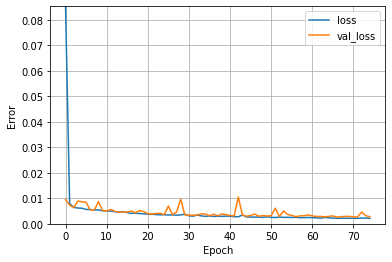

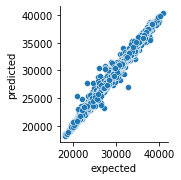

In [9]:
plot_history(history)
sns.pairplot(data=reg_predictions, y_vars=['predicted'], x_vars=['expected'])


In [10]:
utils.save_to_db(reg_predictions, 'reg_predictions')

In [11]:
reg_predictions

,predicted,expected,date_time
0,19753.134766,20010.0,2015-01-01 05:00:00
1,20289.757812,20377.0,2015-01-01 06:00:00
2,23258.691406,23547.0,2015-01-01 10:00:00
3,24404.611328,24713.0,2015-01-01 12:00:00
4,26105.195312,26447.0,2015-01-01 17:00:00
...,...,...,...
6299,28213.363281,28382.0,2018-12-31 08:00:00
6300,27347.058594,27988.0,2018-12-31 13:00:00
6301,29019.904297,29592.0,2018-12-31 17:00:00
6302,30531.826172,29735.0,2018-12-31 19:00:00


# Classifier

In [12]:
sql = """
select
    date_time,
    SIN (0.130 * hour) as hour,
    load as current_load,
    diff1,
    diff2,
    diff3,
    diff5,
    diff8,
    diff13,
    diff24,
    diff37,
    median_diff,
    median_std
from
    ensemble_data
where 
    train = {train_flag} and {where_clause}
""".format

engine = sqlalchemy.create_engine(selects.CONN_STR)

data1 = pd.read_sql_query(sql(where_clause="data_diff >= 0", train_flag=1), con=engine)
data1['target'] = data1.apply(lambda row: 1, axis=1)
data1 = data1.sample(frac=1.0)

data2  = pd.read_sql_query(sql(where_clause="data_diff < 0", train_flag=1), con=engine)
data2 = data2.sample(frac=1.0)

data2['target'] = data2.apply(lambda row: 0, axis=1)

print(len(data2), len(data1))

if len(data1) < len(data2):
    data2 = data2[0:len(data1)]
else:
    data1 = data1[0:len(data2)]
print(len(data2), len(data1))
    
    
train_dataset = pd.concat([data1, data2])

train_dataset = train_dataset.sample(frac=1.0)
train_dataset.pop('date_time')



# Get Testing data.

data1 = pd.read_sql_query(sql(where_clause="data_diff >= 0", train_flag=0), con=engine)
data1['target'] = data1.apply(lambda row: 1, axis=1)

data2 = pd.read_sql_query(sql(where_clause="data_diff < 0", train_flag=0), con=engine)
data2['target'] = data2.apply(lambda row: 0, axis=1)


test_dataset = pd.concat([data1, data2])
test_dataset = test_dataset.sort_values(by ='date_time' )
test_dataset.pop('date_time')

train_features = train_dataset.copy()
train_labels = pd.DataFrame(train_features.pop('target'))

test_features = test_dataset.copy()
test_labels = pd.DataFrame(test_features.pop('target'))

columns = train_features.columns
feature_scaler = Scaler(train_features, 'RobustScaler')
scaled_features = feature_scaler.scale(train_features)
scaled_features.columns = columns

scaled_test_features = feature_scaler.scale(test_features)



14046 10846
10846 10846


In [13]:
train_features

,hour,current_load,diff1,diff2,diff3,diff5,diff8,diff13,diff24,diff37,median_diff,median_std
3121,0.789504,30694.0,3507.5,3157.66670,2537.00,1578.833400,448.888900,-113.64286,98.76,-54.526318,2001.0,809.62370
4007,0.257081,21424.0,-549.0,-835.33330,-1192.50,-1314.500000,-452.888900,-545.78570,-237.80,-341.315800,-514.5,195.49062
8696,0.129634,24329.0,-1180.0,-471.66666,-766.50,-264.833340,-93.555560,-233.00000,101.52,-74.631580,-1134.0,236.30333
335,0.990105,30977.0,677.5,1055.66660,1354.50,1339.166600,778.111100,39.42857,-146.88,-9.263158,221.0,503.82443
2414,0.873133,27320.0,-408.0,-694.66670,-570.50,-319.166660,384.222230,329.78570,-97.52,196.026320,-51.0,327.15054
...,...,...,...,...,...,...,...,...,...,...,...,...
2626,0.969109,32073.0,-703.0,-333.00000,-107.75,72.166664,694.666700,482.57144,132.48,167.500000,-714.0,308.48390
373,0.789504,21552.0,397.5,-97.00000,-492.25,-635.500000,-632.222200,-291.92856,-545.24,-208.526320,2001.0,809.62370
8273,0.515501,25634.0,905.0,649.33330,488.00,190.333330,-116.666664,344.85715,-66.00,4.026316,-57.0,1057.35680
6272,0.380188,24411.0,-298.0,-527.00000,-778.00,-1169.666600,-914.888900,-653.07140,1.56,-254.184200,-178.5,172.45195


In [14]:
import tensorflow.keras as keras
from tensorflow.keras import layers

NUMBER_OF_FEATURES = len(train_features.columns)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

callbacks=[early_stop]

model = keras.Sequential()
model.add(layers.Dense(NUMBER_OF_FEATURES, activation='relu', input_shape=(NUMBER_OF_FEATURES,)))
model.add(layers.Dense(30, activation='relu'))
#model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
history = model.fit(scaled_features, train_labels,epochs=30, batch_size=80, shuffle=True, verbose=0
                    , callbacks=[early_stop], validation_split=0.2)
score = model.evaluate(scaled_test_features, test_labels,verbose=1)
print(score)

197/197 [==============================] - 1s 3ms/step - loss: 0.1719 - accuracy: 0.9397
[0.1718674898147583, 0.9397208094596863]


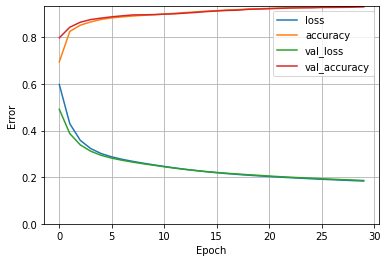

In [15]:
plot_history(history)

In [16]:
scaled_features = feature_scaler.scale(test_features)
class_predictions = pd.DataFrame(model.predict(scaled_features))
class_predictions.columns = ['percentage']
class_predictions['predicted'] = class_predictions.apply(lambda row: 1 if row.percentage > 0.5 else 0, axis=1)
class_predictions.pop('percentage')



reg_predictions['up_down'] = class_predictions.predicted.values
reg_predictions['median_std'] = test_features.median_std.values
reg_predictions['current_load'] = test_features.current_load.values

reg_predictions['diff'] = reg_predictions.apply(lambda row: row.expected - row.current_load, axis=1)

reg_predictions['t_flag1'] = reg_predictions.apply(lambda row: 1 if (row.up_down == 1) and (row.current_load < row.expected) else 0, axis=1)
reg_predictions['t_flag0'] = reg_predictions.apply(lambda row: 1 if (row.up_down == 0) and (row.current_load > row.expected) else 0, axis=1)

reg_predictions['f1'] = reg_predictions.apply(lambda row: 1 if row.predicted > row.current_load else 0, axis=1)

reg_predictions


,predicted,expected,date_time,up_down,median_std,current_load,diff,t_flag1,t_flag0,f1
0,19753.134766,20010.0,2015-01-01 05:00:00,1,968.62290,19905.0,105.0,1,0,0
1,20289.757812,20377.0,2015-01-01 06:00:00,1,1314.48060,20010.0,367.0,1,0,1
2,23258.691406,23547.0,2015-01-01 10:00:00,1,451.14630,22250.0,1297.0,1,0,1
3,24404.611328,24713.0,2015-01-01 12:00:00,1,354.43260,24133.0,580.0,1,0,1
4,26105.195312,26447.0,2015-01-01 17:00:00,1,1060.72280,23606.0,2841.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
6299,28213.363281,28382.0,2018-12-31 08:00:00,1,600.99915,25969.0,2413.0,1,0,1
6300,27347.058594,27988.0,2018-12-31 13:00:00,0,436.00687,28636.0,-648.0,0,1,0
6301,29019.904297,29592.0,2018-12-31 17:00:00,1,1060.72280,26738.0,2854.0,1,0,1
6302,30531.826172,29735.0,2018-12-31 19:00:00,1,897.00500,30653.0,-918.0,0,0,0


In [17]:
reg_predictions

,predicted,expected,date_time,up_down,median_std,current_load,diff,t_flag1,t_flag0,f1
0,19753.134766,20010.0,2015-01-01 05:00:00,1,968.62290,19905.0,105.0,1,0,0
1,20289.757812,20377.0,2015-01-01 06:00:00,1,1314.48060,20010.0,367.0,1,0,1
2,23258.691406,23547.0,2015-01-01 10:00:00,1,451.14630,22250.0,1297.0,1,0,1
3,24404.611328,24713.0,2015-01-01 12:00:00,1,354.43260,24133.0,580.0,1,0,1
4,26105.195312,26447.0,2015-01-01 17:00:00,1,1060.72280,23606.0,2841.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
6299,28213.363281,28382.0,2018-12-31 08:00:00,1,600.99915,25969.0,2413.0,1,0,1
6300,27347.058594,27988.0,2018-12-31 13:00:00,0,436.00687,28636.0,-648.0,0,1,0
6301,29019.904297,29592.0,2018-12-31 17:00:00,1,1060.72280,26738.0,2854.0,1,0,1
6302,30531.826172,29735.0,2018-12-31 19:00:00,1,897.00500,30653.0,-918.0,0,0,0


In [18]:
utils.save_to_db(reg_predictions, 'reg_predictions2')

In [19]:
reg_predictions["diff"] = reg_predictions.apply(lambda row: 1 if row.predicted - row.expected >= 0 else 0, axis=1)

In [20]:
reg_predictions

,predicted,expected,date_time,up_down,median_std,current_load,diff,t_flag1,t_flag0,f1
0,19753.134766,20010.0,2015-01-01 05:00:00,1,968.62290,19905.0,0,1,0,0
1,20289.757812,20377.0,2015-01-01 06:00:00,1,1314.48060,20010.0,0,1,0,1
2,23258.691406,23547.0,2015-01-01 10:00:00,1,451.14630,22250.0,0,1,0,1
3,24404.611328,24713.0,2015-01-01 12:00:00,1,354.43260,24133.0,0,1,0,1
4,26105.195312,26447.0,2015-01-01 17:00:00,1,1060.72280,23606.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
6299,28213.363281,28382.0,2018-12-31 08:00:00,1,600.99915,25969.0,0,1,0,1
6300,27347.058594,27988.0,2018-12-31 13:00:00,0,436.00687,28636.0,0,0,1,0
6301,29019.904297,29592.0,2018-12-31 17:00:00,1,1060.72280,26738.0,0,1,0,1
6302,30531.826172,29735.0,2018-12-31 19:00:00,1,897.00500,30653.0,1,0,0,0


In [ ]:
utils.save_to_db(reg_predictions, 'reg_predictions')